In [108]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [109]:
pd.set_option('display.max_colwidth', None)

## EDA

In [110]:
train_data = pd.read_csv('../raw_data/train.csv')
train_data = train_data.drop(['id', 'orig_id'], axis=1)

In [111]:
#val_data = pd.read_csv('../raw_data/validation.csv')
#val_data = val_data.drop(['id', 'orig_id'], axis=1)

In [112]:
#test_data = pd.read_csv('../raw_data/test.csv')
#test_data = test_data.drop(['id', 'orig_id'], axis=1)

In [113]:
train_data.head(3)

,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in ""Harry Potter and the Order of the Phoenix"" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. ""I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar,"" he told an Australian interviewer earlier this month. ""I don't think I'll be particularly extravagant. ""The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."" At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film ""Hostel: Part II,"" currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. ""I'll definitely have some sort of party,"" he said in an interview. ""Hopefully none of you will be reading about it."" Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. ""People are always looking to say 'kid star goes off the rails,'"" he told reporters last month. ""But I try very hard not to go that way because it would be too easy for them."" His latest outing as the boy wizard in ""Harry Potter and the Order of the Phoenix"" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called ""My Boy Jack,"" about author Rudyard Kipling and his son, due for release later this year. He will also appear in ""December Boys,"" an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's ""Equus."" Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: ""I just think I'm going to be more sort of fair game,"" he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed.",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund .
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the ""forgotten floor,"" where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the ""forgotten floor."" Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually ""avoidable felonies."" He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow directions, according to Leifman. So, they end up on the ninth floor severely mentally disturbed, but not getting any real help because they're in jail. We toured the jail with Leifman. He is well

In [114]:
print(f"train_data.shape: {train_data.shape}")

train_data.shape: (287113, 2)


In [117]:
train_data.isna().sum()

article       0
highlights    0
dtype: int64

In [118]:
#val_data.isna().sum()

In [119]:
#test_data.isna().sum()

### Dealing with duplicates

In [120]:
train_data.duplicated(subset=['article', 'highlights']).sum()

3098

In [121]:
train_data = train_data.drop_duplicates(subset=['article', 'highlights'])
train_data.shape

(284015, 2)

In [122]:
#val_data.duplicated(subset=['article', 'highlights']).sum()

In [123]:
#test_data.duplicated(subset=['article', 'highlights']).sum()

In [124]:
#test_data = test_data.drop_duplicates(subset=['article', 'highlights'])
#test_data.shape

### Cleaning data

In [125]:
def preprocessing(sentence, remove_stopwords=True):
    '''
    Preprocessing text: lower case, 
                        deleting punctuation, 
                        replacing contructions with equivalent,
                        deleting stop words
    '''

    # Lowercasing
    sentence = sentence.lower()
   
    # Removing numbers
    #sentence = ''.join(char for char in sentence if not char.isdigit())
 
    # Removing punctuation
    sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'\n', ' ', sentence)
    sentence = re.sub(r'\<a href', ' ', sentence)
    sentence = re.sub(r'&amp;', '', sentence) 
    sentence = re.sub(r'[~^_`"\-;%(){|}\+&<=>\*%.,!\?:#$@\[\]/]', ' ', sentence)
    sentence = re.sub(r'<br />', ' ', sentence)
    
    expanded = []   
    for word in sentence.split():
      # using contractions.fix to expand the shortened words (can't => can not)
      expanded.append(contractions.fix(word, slang=False))
        
    expanded_sentence = ' '.join(expanded)
    sentence = re.sub(r'\'', ' ', expanded_sentence)
    
    # Removing whitespaces
    sentence = sentence.strip()
                
    if remove_stopwords:
        stop_words = set(stopwords.words('english')) ## defining stopwords    
        sentence_list = [w for w in sentence.split() if not w in stop_words]
        sentence = (" ".join(sentence_list)).strip()
        
    return sentence

**testing all on a subset of data**

In [126]:
%%time
clean_articles = []
for summary in train_data['article'][:100]:
    clean_articles.append(preprocessing(summary, remove_stopwords=True))
print('Cleaning Articles Complete')


<timed exec>:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


Cleaning Articles Complete
CPU times: user 182 ms, sys: 21.9 ms, total: 204 ms
Wall time: 231 ms


In [127]:
%%time
clean_summaries = []
for summary in train_data['highlights'][:100]:
    clean_summaries.append(preprocessing(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')


Cleaning Summaries Complete
CPU times: user 13.6 ms, sys: 1.64 ms, total: 15.2 ms
Wall time: 15 ms


<timed exec>:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


In [128]:
for i in range(2):
    print("Article:",clean_articles[i])
    print("\n")
    print("Summary:",clean_summaries[i])
    print("\n")

Article: london england reuters harry potter star daniel radcliffe gains access reported £20 million 41 1 million fortune turns 18 monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties plan one people soon turn 18 suddenly buy massive sports car collection something similar told australian interviewer earlier month think particularly extravagant things like buying things cost 10 pounds books cds dvds 18 radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details mark landmark birthday wraps agent publicist comment plans definitely sort party said interview hopefully none reading radcliffe earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking say kid star goes ra

### Potential threshhold for news extraction

 For API/scrapping part can be useful to define what we consider as an article

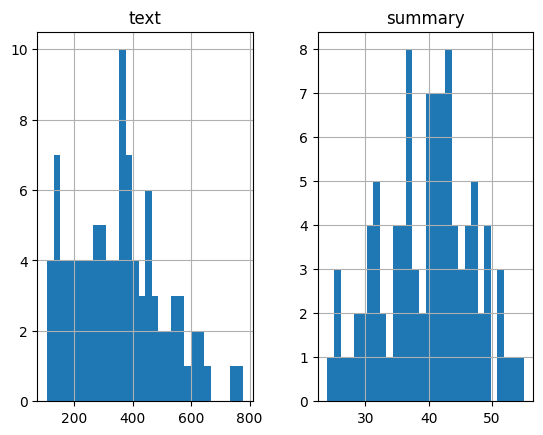

In [129]:
# word count
article_wc = []
summary_wc = []

# populate the lists with sentence lengths
for i in clean_articles:
      article_wc.append(len(i.split()))

for i in clean_summaries:
      summary_wc.append(len(i.split()))

length_df = pd.DataFrame({'text':article_wc, 'summary':summary_wc})
length_df.hist(bins = 30)
plt.show()

In [131]:
clean_df = pd.DataFrame()
clean_df['article'] = clean_articles
clean_df['summary'] = clean_summaries

In [132]:
clean_df[:2]

,article,summary
0,london england reuters harry potter star daniel radcliffe gains access reported £20 million 41 1 million fortune turns 18 monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties plan one people soon turn 18 suddenly buy massive sports car collection something similar told australian interviewer earlier month think particularly extravagant things like buying things cost 10 pounds books cds dvds 18 radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details mark landmark birthday wraps agent publicist comment plans definitely sort party said interview hopefully none reading radcliffe earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking say kid star goes rails told reporters last month try hard go way would easy latest outing boy wizard harry potter order phoenix breaking records sides atlantic reprise role last two films watch reporter give review potter latest » life beyond potter however londoner filmed tv movie called boy jack author rudyard kipling son due release later year also appear december boys australian film four boys escape orphanage earlier year made stage debut playing tortured teenager peter shaffer equus meanwhile braced even closer media scrutiny legally adult think going sort fair game told reuters e mail friend copyright 2007 reuters rights reserved material may published broadcast rewritten redistributed,harry potter star daniel radcliffe gets £20m fortune as he turns 18 monday young actor says he has no plans to fritter his cash away radcliffe s earnings from first five potter films have been held in trust fund
1,editor note behind scenes series cnn correspondents share experiences covering news analyze stories behind events soledad brien takes users inside jail many inmates mentally ill inmate housed forgotten floor many mentally ill inmates housed miami trial miami florida cnn ninth floor miami dade pretrial detention facility dubbed forgotten floor inmates severe mental illnesses incarcerated ready appear court often face drug charges charges assaulting officer charges judge steven leifman says usually avoidable felonies says arrests often result confrontations police mentally ill people often told police arrive scene confrontation seems exacerbate illness become paranoid delusional less likely follow directions according leifman end ninth floor severely mentally disturbed getting real help jail toured jail leifman well known miami advocate justice mentally ill even though exactly welcomed open arms guards given permission shoot videotape tour floor go inside forgotten floor » first hard determine people prisoners wearing sleeveless robes imagine cutting holes arms feet heavy wool sleeping bag kind look like designed keep mentally ill patients injuring also shoes laces mattresses leifman says one third people miami dade county jails mentally ill says sheer volume overwhelming system result see ninth floor course jail supposed warm comforting lights glare cells tiny loud see two sometimes three men sometimes robes sometimes naked lying sitting cells son president need get one man shouts absolutely serious convinced help way could reach white house leifman tells prisoner patients often circulate system occasionally stabilizing mental hospital return jail face charges brutally unjust mind become strong advocate changing things miami meal later talk things got way mental patients leifman says 200 years ago people considered lunatics locked jails even charges considered unfit society years says public outcry mentally ill moved jails hospitals leifman says many mental hospitals horrible shut patients go nowhere streets became many cases homeless says never got treatmen

In [133]:
# adding start and stop to sequence
clean_df['summary'] = clean_df['summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [134]:
clean_df[:1]

,article,summary
0,london england reuters harry potter star daniel radcliffe gains access reported £20 million 41 1 million fortune turns 18 monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties plan one people soon turn 18 suddenly buy massive sports car collection something similar told australian interviewer earlier month think particularly extravagant things like buying things cost 10 pounds books cds dvds 18 radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details mark landmark birthday wraps agent publicist comment plans definitely sort party said interview hopefully none reading radcliffe earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking say kid star goes rails told reporters last month try hard go way would easy latest outing boy wizard harry potter order phoenix breaking records sides atlantic reprise role last two films watch reporter give review potter latest » life beyond potter however londoner filmed tv movie called boy jack author rudyard kipling son due release later year also appear december boys australian film four boys escape orphanage earlier year made stage debut playing tortured teenager peter shaffer equus meanwhile braced even closer media scrutiny legally adult think going sort fair game told reuters e mail friend copyright 2007 reuters rights reserved material may published broadcast rewritten redistributed,_START_ harry potter star daniel radcliffe gets £20m fortune as he turns 18 monday young actor says he has no plans to fritter his cash away radcliffe s earnings from first five potter films have been held in trust fund _END_


In [135]:
del clean_articles
del clean_summaries

In [136]:
list(clean_df['summary'][:3])

['_START_ harry potter star daniel radcliffe gets £20m fortune as he turns 18 monday young actor says he has no plans to fritter his cash away radcliffe s earnings from first five potter films have been held in trust fund _END_',
 '_START_ mentally ill inmates in miami are housed on the forgotten floor judge steven leifman says most are there as a result of avoidable felonies while cnn tours facility patient shouts i am the son of the president leifman says the system is unjust and he is fighting for change _END_',
 '_START_ new i thought i was going to die driver says man says pickup truck was folded in half he just has cut on face driver i probably had a 30 35 foot free fall minnesota bridge collapsed during rush hour wednesday _END_']

## Tokenizing